In [ ]:
%load_ext autoreload
%autoreload 2

import glob
from string import digits
import math 
import sys

import yaml
import pandas as pd
import numpy as np
import xarray as xr
import pycountry
import geopandas as gpd
import scipy.interpolate as spi

import matplotlib.pyplot as plt
import shapely 
import seaborn as sns

sys.path.append('../src/construct/')
import util
import annual_heat_demand

countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Czech Republic", "Cyprus", "Denmark", "Estonia", 
    "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", 
    "Lithuania", "Luxembourg", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia",
    "Slovenia", "Spain", "Sweden", "United Kingdom", "Albania", "Bosnia and Herzegovina", 
    "North Macedonia", "Montenegro", "Norway", "Serbia", "Switzerland", "Iceland"
]
ch_end_use = "https://www.bfe.admin.ch/bfe/en/home/versorgung/statistik-und-geodaten/energiestatistiken/energieverbrauch-nach-verwendungszweck.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvOTg1NA==.html"
ch_energy_use = "https://www.bfe.admin.ch/bfe/en/home/versorgung/statistik-und-geodaten/energiestatistiken/gesamtenergiestatistik.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvNzUxOQ==.html"

idx = pd.IndexSlice

%matplotlib inline

In [4]:
with open('../config/default.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [5]:
country_codes = {
    util.get_alpha2(i, eurostat=True): util.get_alpha3(i) for i in countries
}
energy_balance_dfs = annual_heat_demand.get_energy_balances('../build/annual_energy_balances.csv', '../data/energy_balance_carrier_names.csv', country_codes)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
annual_consumption = annual_heat_demand.get_household_energy_consumption('../data/automatic/hh_end_use.tsv.gz', '../data/automatic/ch_hh_end_use.xlsx', '../data/energy_balance_carrier_names.csv', country_codes)


annual_consumption = annual_heat_demand.get_commercial_energy_consumption(
    energy_balance_dfs['com'], '../data/automatic/ch_hh_end_use.xlsx', 
    '../data/commercial/JRC_IDEES_commercial_end_use_consumption.csv', country_codes, 
    annual_consumption
)

annual_consumption = annual_heat_demand.hardcoded_country_cleanup(annual_consumption, energy_balance_dfs['hh'])

annual_consumption = annual_heat_demand.get_industrial_energy_consumption(
    energy_balance_dfs['ind'], '../data/automatic/ch_hh_end_use.xlsx', 
    '../data/industry/JRC_IDEES_industry_end_use_consumption.csv', 
    '../data/energy_balance_category_names.csv',
    country_codes, annual_consumption
) 

In [12]:
dwellings = pd.read_csv('../data/automatic/dwellings.tsv.gz', delimiter='\t', index_col=0)
dwellings.index = dwellings.index.str.split(',', expand=True).rename(['housing', 'building_type', 'unit', 'year'])
dwellings.columns = dwellings.columns.str.strip().rename('region')

dwellings = dwellings.droplevel(['unit', 'year'])
dwellings

region                      BE     BE1    BE10   BE100      BE2    BE21  \
housing building_type                                                     
DW      NRES            105455   20101   20101   20101    51449   15870   
        RES            5203491  560985  560985  560985  3005940  819522   
        RES1           3464147   89185   89185   89185  2120473  508649   
        RES2            257822   43864   43864   43864   117648   43242   
        RES_GE3        1481522  427936  427936  427936   767819  267631   
        TOTAL          5308946  581086  581086  581086  3057389  835392   
        UNK                  0       0       0       0        0       0   
DW_NOC  NRES             44998    8138    8138    8138    22772    7234   
        RES             700297   85366   85366   85366   421430   95490   
        RES1            283553    6789    6789    6789   162920   36975   
        RES2             51518    8976    8976    8976    26031    9855   
        RES_GE3         365226   69601   69601   69601   232479   48660   
        TOTAL           745295   93504   93504   93504   444202  102724   
        UNK                  0       0       0       0        0       0   
DW_OC   NRES             60457   11963   11963   11963    28677    8636   
        RES            4503194  475619  475619  475619  2584510  724032   
        RES1           3180594   82396   82396   82396  1957553  471674   
        RES2            206304   34888   34888   34888    91617   33387   
        RES_GE3        1116296  358335  358335  358335   535340  218971   
        TOTAL          4563651  487582  487582  487582  2613187  732668   
        UNK                  0       0       0       0        0       0   
UNK     NRES                 0       0       0       0        0       0   
        RES                  0       0       0       0        0       0   
        RES1                 0       0       0       0        0       0   
        RES2                 0       0       0       0        0       0   
        RES_GE3              0       0       0       0        0       0   
        TOTAL                0       0       0       0        0       0   
        UNK                  0       0       0       0        0       0   

region                  BE211   BE212   BE213    BE22  ...  CH062  CH063  \
housing building_type                                  ...                 
DW      NRES            10511    2454    2905    5900  ...    891   3069   
        RES            473677  147104  198741  369455  ...  16931  67476   
        RES1           236584  112608  159457  282984  ...   5022  17213   
        RES2            30398    6394    6450   16488  ...   4134  10862   
        RES_GE3        206695   28102   32834   69983  ...   7775  39401   
        TOTAL          484188  149558  201646  375355  ...  17822  70545   
        UNK                 0       0       0       0  ...      0      0   
DW_NOC  NRES             5134     937    1163    2219  ...      0      0   
        RES             59133   14157   22200   36318  ...      0      0   
        RES1            15952    8227   12796   17268  ...      0      0   
        RES2             7237    1316    1302    2990  ...      0      0   
        RES_GE3         35944    4614    8102   16060  ...      0      0   
        TOTAL           64267   15094   23363   38537  ...      0      0   
        UNK                 0       0       0       0  ...      0      0   
DW_OC   NRES             5377    1517    1742    3681  ...      0      0   
        RES            414544  132947  176541  333137  ...      0      0   
        RES1           220632  104381  146661  265716  ...      0      0   
        RES2            23161    5078    5148   13498  ...      0      0   
        RES_GE3        170751   23488   24732   53923  ...      0      0   
        TOTAL          419921  134464  178283  336818  ...      0      0   
        UNK                 0       0       0       0  ...      0      0   
U

In [144]:
units = gpd.read_file('../land-eligibility/build/eurospores/units.geojson')
nuts_2010 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2010_4326_LEVL_3.geojson')
nuts_to_eurospores = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations', index_col='NUTS3')
nuts_to_eurospores = nuts_to_eurospores.loc[nuts_to_eurospores.Source == 'NUTS3', 'EuroSPORES']
nuts_to_eurospores.index = nuts_to_eurospores.index.str.replace('GR', 'EL')
foo = util.nuts_to_nuts(nuts_2010, nuts_to_eurospores, units)

Choosing DEU_2 with 99.82902478894911% of DE406 area
Choosing DEU_4 with 99.89192030206023% of DE407 area
Choosing DEU_4 with 99.77156859087883% of DE40B area
Choosing DEU_2 with 99.94436694575559% of DE40C area
Choosing DEU_2 with 99.97706833230788% of DE40E area
Choosing DEU_2 with 99.9858315951264% of DE40F area
Choosing DEU_4 with 99.89842488780009% of DE40G area
Choosing DEU_2 with 99.87162557228704% of DE40H area
Choosing DEU_4 with 99.92813136257661% of DED44 area
skipping EL221 entirely
skipping EL222 entirely
skipping EL223 entirely
skipping EL224 entirely
skipping EL411 entirely
skipping EL412 entirely
skipping EL413 entirely
skipping EL421 entirely
skipping EL422 entirely
skipping EL431 entirely
skipping EL432 entirely
skipping EL433 entirely
skipping EL434 entirely
skipping ES531 entirely
skipping ES532 entirely
skipping ES533 entirely
skipping ES630 entirely
skipping ES640 entirely
Choosing FIN_2 with 99.99747799219722% of FI1D2 area
Choosing FIN_2 with 99.99872309078336% 

In [156]:
dwellings.groupby(foo.regions, axis=1).sum().T.reindex(units.id)

housing            DW                                                    \
building_type    NRES      RES     RES1    RES2  RES_GE3    TOTAL   UNK   
id                                                                        
ALB_1             NaN      NaN      NaN     NaN      NaN      NaN   NaN   
AUT_1           51715  1014142   298184  179112   536846  1065857     0   
AUT_2           45226  1346535   513419  237406   595710  1391761     0   
AUT_3           44418  1939372   630463  153608  1155301  1983790     0   
BEL_1          105455  5203491  3464147  257822  1481522  5308946     0   
...               ...      ...      ...     ...      ...      ...   ...   
SVN_1           26455   818201   452016   58984   307201   844656     0   
SWE_1            2421   130671    77403     787    52481   133431   339   
SWE_2            8426   499754   301926    4027   193801   508894   714   
SWE_3           52859  3190634  1540136   10221  1640277  3247677  4184   
SWE_4           15730   916818   520946    2355   393517   934225  1677   

housing       DW_NOC                  ...    DW_OC                 UNK       \
building_type   NRES     RES    RES1  ...  RES_GE3    TOTAL   UNK NRES  RES   
id                                    ...                                     
ALB_1            NaN     NaN     NaN  ...      NaN      NaN   NaN  NaN  NaN   
AUT_1          17362  200039   43927  ...   421929   848456     0    0    0   
AUT_2          14171  214337   65958  ...   496719  1163253     0    0    0   
AUT_3          16029  334512  129586  ...   988391  1633249     0    0    0   
BEL_1          44998  700297  283553  ...  1116296  4563651     0    0    0   
...              ...     ...     ...  ...      ...      ...   ...  ...  ...   
SVN_1           8023  166506  107896  ...   256902   670127     0    0    0   
SWE_1            662   24428   15074  ...    43310   108297   295    0    0   
SWE_2           2413  110495   77474  ...   161799   395874   602    0    0   
SWE_3          11803  529055  321690  ...  1435236  2706575  3940    0    0   
SWE_4           3229  139607   89408  ...   343857   791259  1547    0    0   

housing                                     
building_type RES1 RES2 RES_GE3 TOTAL  UNK  
id                                          
ALB_1          NaN  NaN     NaN   NaN  NaN  
AUT_1            0    0       0     0    0  
AUT_2            0    0       0     0    0  
AUT_3            0    0       0     0    0  
BEL_1            0    0       0     0    0  
...            ...  ...     ...   ...  ...  
SVN_1            0    0       0     0    0  
SWE_1            0    0       0     0    0  
SWE_2            0    0       0     0    0  
SWE_3            0    0       0     0    0  
SWE_4            0    0       0     0    0  

[98 rows x 28 columns]

In [88]:
bar = nuts_2010.merge(nuts_to_eurospores.rename('regions'), left_on='id', right_index=True, how='outer')
bar = bar[bar.regions.isna()].set_index('id')

In [134]:
foobar = gpd.overlay(bar, units, keep_geom_type=False)
foobar[foobar.FID == 'ES211']

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,regions,id,country_code,name,type,proper,geometry
67,NL,Overig Groningen,3.0,NL113,NL113,NaN,NLD_1,NLD,Netherlands,country,True,"GEOMETRYCOLLECTION (POINT (6.59705 53.53474), ..."


In [137]:
foobar[foobar.FID == 'EL211']

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,regions,id,country_code,name,type,proper,geometry


In [114]:
units.intersects(nuts_2010[nuts_2010.id == 'NL111']).sum()

0

In [87]:
util.get_alpha3(nuts_2010[nuts_2010.id == 'NL113'].CNTR_CODE.item())

'NLD'

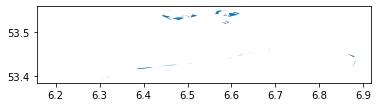

In [105]:
gpd.overlay(bar.loc[['NL113']], units, how='identity')

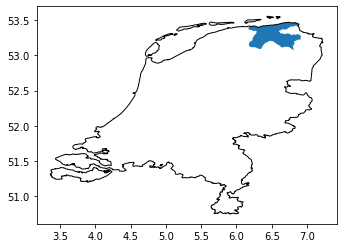

In [123]:
ax = bar.loc[['NL113']].plot()
units[units.country_code == 'NLD'].plot(ax=ax, fc='None', ec='black')

In [27]:
dwellings.groupby([foo.index]

SyntaxError: unexpected EOF while parsing (<ipython-input-27-adef9bdb4cd3>, line 1)

In [15]:
heat_tech_params = {
    "carnot_performance": 0.36,  # [Nouvel_2015]
    "natural_gas_eff": 0.85,  #
    "oil_eff": 0.85,  #
    "coal_eff": 0.85, #
    "wood_eff": 0.8,  # [mermoud_2015]
    "solar_thermal_eff": 1,  # Eurostat energy balances method
    "direct_electric_eff": 1,  # must be 1 for the time being (we assume 1 -> 1 electricity -> heat conversion)
    "space_heating_temp": 36,  # degrees C [Nouvel_2015]
    "water_heating_temp": 52  # degrees C [Nouvel_2015]
}

hh_end_use = "../data/automatic/hh_end_use.tsv.gz"
ch_end_use = "../data/automatic/ch_hh_end_use.xlsx"
        
def get_national_heat_demand(hh_end_use, ch_end_use, countries, heat_tech_params):
    """
    Get consumption of heat techs and convert to demand for heating
    """
    annual_consumption = get_household_energy_consumption(
        hh_end_use, ch_end_use, countries
    )

    efficiencies = {
        'biogas': heat_tech_params['biogas_eff'],
        'biomass': heat_tech_params['biomass_eff'],
        'coal': heat_tech_params['coal_eff'],
        'natural_gas': heat_tech_params['natural_gas_eff'],
        'oil': heat_tech_params['oil_eff'],
        'solar_thermal': heat_tech_params['solar_thermal_eff'],
        'direct_electric': 1,  # don't need to deal with heat pump COP if direct electric is 100% efficient
        'heat': 1,
        # heat demand met by heat pumps = heat pump electricity + ambient heat
        'heat_pump': 1,
        'ambient_heat': 1
    }

    demand = pd.Series(index=annual_consumption.index)
    for k, v in efficiencies.items():
        demand += annual_consumption[annual_consumption.carrier_name == k] * v

    return demand

def get_household_energy_consumption(
    hh_end_use, ch_end_use, countries
):
    """
    Combine annual energy balance information with data on household
    end use energy consumption
    """

    country_codes = {get_alpha2(i, eurostat=True): get_alpha3(i) for i in countries}
    
    hh_end_use_df = pd.read_csv(hh_end_use, delimiter='\t', index_col=0)
    hh_end_use_df.index = (
        hh_end_use_df.index.str.split(',', expand=True)
        .rename(['cat_code', 'carrier_code', 'unit', 'country'])
    )
    hh_end_use_df.columns = hh_end_use_df.columns.astype(int).rename('year')
    hh_end_use_df = (
        hh_end_use_df
        .loc[idx[
            END_USE_CAT_NAMES.keys(), 
            HH_END_USE_CARRIERS_ALL.keys(), 
            'TJ', 
            country_codes.keys()
        ], :]
        .transform(to_numeric)
        .astype(float)
        .dropna(how='all')
    )
    hh_end_use_df.index = (
        hh_end_use_df.index
        .remove_unused_levels()
        .set_levels([END_USE_CAT_NAMES.values(), HH_END_USE_CARRIERS_ALL.values(), country_codes.values()],
                    level=['cat_code', 'carrier_code', 'country'])
        .rename(['cat_name', 'carrier_name', 'country_code'], level=['cat_code', 'carrier_code', 'country'])
    )

    ch_hh_end_use_df_tot = get_ch_sheet(  # maybe remove - do we need total hh energy consumption info?
        ch_end_use, 'Tabelle 15', skipfooter=5, translation=CH_HH_END_USE_TRANSLATION
    )
    ch_hh_end_use_df_sh = get_ch_sheet(
        ch_end_use, 'Tabelle 18', skipfooter=8, translation=CH_ENERGY_CARRIER_TRANSLATION
    )
    ch_hh_end_use_df_hw = get_ch_sheet(
        ch_end_use, 'Tabelle 20', skipfooter=5, translation=CH_ENERGY_CARRIER_TRANSLATION
    )
    ch_hh_end_use_df_c = get_ch_sheet(
        ch_end_use, 'Tabelle21', skipfooter=4, translation=CH_ENERGY_CARRIER_TRANSLATION
    )

    ch_hh_end_use_df = (
        pd.concat(
            [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c],
            keys=('space_heating', 'water_heating', 'cooking'),
            names=['cat_name', 'carrier_name']
        )
        .append(
            ch_hh_end_use_df_tot  # maybe remove - do we need total hh energy consumption info?
            .assign(carrier_name='total')
            .set_index('carrier_name', append=True)
        )
        .assign(unit='TJ', country_code='CHE')
        .set_index(['unit', 'country_code'], append=True)
        .drop('Δ ’00 – ’18', axis=1)
    )
    ch_hh_end_use_df.columns = ch_hh_end_use_df.columns.astype(int)

    hh_end_use_df = (
        hh_end_use_df
        .append(ch_hh_end_use_df, sort=True)
    )
    hh_end_use_df = (
        hh_end_use_df
        .sort_index()
        .where(hh_end_use_df > 0)
        .dropna(how='all')
    )
    return hh_end_use_df


def get_ch_sheet(path_to_excel, sheet, skipfooter, translation=None):
    _df = (
        pd.read_excel(
        path_to_excel, sheet_name=sheet, skiprows=9, skipfooter=skipfooter, index_col=1)
        .drop('Unnamed: 0', axis=1)
    )
    _df.index = _df.index.str.strip()
    if translation is not None:
        return _df.groupby(translation).sum()
    else:
        return _df

In [16]:
annual_consumption = get_household_energy_consumption(
    hh_end_use, ch_end_use, countries
)

In [17]:
efficiencies = pd.Series({
    'biogas': heat_tech_params['natural_gas_eff'],
    'biomass': heat_tech_params['wood_eff'],
    'coal': heat_tech_params['coal_eff'],
    'natural_gas': heat_tech_params['natural_gas_eff'],
    'oil': heat_tech_params['oil_eff'],
    'solar_thermal': heat_tech_params['solar_thermal_eff'],
    'direct_electric': 1,  # don't need to deal with heat pump COP if direct electric is 100% efficient
    'heat': 1,
    # heat demand met by heat pumps = heat pump electricity + ambient heat
    'heat_pump': 1,
    'ambient_heat': 1
})
demand = annual_consumption.mul(efficiencies, level='carrier_name', axis=0).sum(level=['cat_name', 'country_code'])
demand = demand.where(demand > 0)

In [41]:
def extrapolate(x):
    if x.dropna().empty:
        return x
    elif len(x.dropna()) == 1:
        return x.fillna(x.mean())
    else:
        return pd.Series(index=x.index, data=spi.interp1d(x.dropna().index, x.dropna().values, fill_value="extrapolate")(x.index))
foo = demand.astype(float).apply(extrapolate, axis=1)

In [18]:
pop_polys_with_hdd = gpd.read_file('../build/merra_2_pop_polys.geojson')
areas = pop_polys_with_hdd.area
country_hdd = pop_polys_with_hdd.dropna().groupby('id').agg(lambda x: np.average(x, weights=areas.loc[x.index])).drop(columns=['proper', 'population'])
demand.head()

2000  2001  2002  2003  2004  2005  2006  2007  2008  \
cat_name country_code                                                         
all      BEL            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
         CYP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
         DEU            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
         DNK            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
         ESP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                       2009         2010          2011         2012  \
cat_name country_code                                                 
all      BEL            NaN  198580.2042  181601.98875  185560.2533   
         CYP            NaN          NaN           NaN          NaN   
         DEU            NaN          NaN           NaN          NaN   
         DNK            NaN          NaN           NaN          NaN   
         ESP            NaN          NaN           NaN          NaN   

                              2013          2014          2015         2016  \
cat_name country_code                                                         
all      BEL           195403.4735  173597.47945  185657.14615  193282.7252   
         CYP                   NaN           NaN           NaN          NaN   
         DEU            77981.2592           NaN  100046.35500   88985.5671   
         DNK                   NaN           NaN           NaN          NaN   
         ESP                   NaN           NaN  603408.12390  634337.5565   

                               2017          2018  
cat_name country_code                              
all      BEL           195488.74635  180063.76505  
         CYP                    NaN    6980.50050  
         DEU            95386.47195   86303.66390  
         DNK           214269.63010  212376.04795  
         ESP           635780.78950  623871.43500

In [30]:
country_hdd.columns = country_hdd.columns.astype(int)
demand.div(country_hdd, level='country_code', axis=0)

2000  2001  2002  2003  2004  2005  2006  2007  \
cat_name      country_code                                                   
all           BEL            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              CYP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              DEU            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              DNK            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              ESP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              EST            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              GRC            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              HRV            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              HUN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              IRL            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              ITA            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              LUX            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              LVA            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              MKD            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              NLD            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              NOR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              POL            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              SVK            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              SVN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              SWE            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              BIH            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              ALB            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              AUT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              BGR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              CZE            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              FIN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              FRA            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              GBR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              LTU            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              MNE            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                          ...   ...   ...   ...   ...   ...   ...   ...   
water_heating ESP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              EST            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              GRC            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              HRV            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              HUN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              MKD            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              NLD            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              NOR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              BIH            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              ALB            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              AUT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              BGR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              CYP            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              CZE            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              DEU            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              FIN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              FRA            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              GBR            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
              IRL            NaN   NaN   NaN   NaN

In [12]:
pop_polys_with_hdd.columns = [int(i) if isinstance(i, str) and i.isnumeric() else i for i in pop_polys_with_hdd.columns]
pop_polys_with_hdd.loc[pop_polys_with_hdd.fillna(0).population == 0, ['population'] + [i for i in range(2000, 2019)]] = 0

In [13]:
country_sums = pop_polys_with_hdd.fillna(0).groupby('country_code').sum().reindex(pd.Index(pop_polys_with_hdd.country_code)).set_index(pop_polys_with_hdd.index)
pop_with_hdd_weights = pop_polys_with_hdd.div(country_sums).assign(country_code=pop_polys_with_hdd.country_code).reset_index().set_index(['site', 'country_code'])
pop_with_hdd_weights.head()

/cluster/work/apatt/brynmorp/miniconda/envs/land-eligibility/lib/python3.6/site-packages/pandas/core/generic.py:7392: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


id  population      2000      2001      2002      2003  \
site country_code                                                            
100  PRT           NaN    0.006246  0.028445  0.027811  0.028868  0.027486   
     ESP           NaN    0.000122  0.004792  0.004704  0.004750  0.004674   
1002 DNK           NaN    0.000030  0.020768  0.020819  0.020423  0.020662   
1003 DNK           NaN    0.000115  0.021282  0.021475  0.021030  0.021099   
1004 DNK           NaN    0.000251  0.021569  0.021713  0.021272  0.021150   

                       2004      2005      2006      2007    ...         2009  \
site country_code                                            ...                
100  PRT           0.027139  0.027099  0.027185  0.027232    ...     0.027632   
     ESP           0.004610  0.004615  0.004723  0.004639    ...     0.004517   
1002 DNK           0.020562  0.020768  0.020460  0.020206    ...     0.020609   
1003 DNK           0.021024  0.021290  0.020839  0.021008    ...     0.021128   
1004 DNK           0.021141  0.021400  0.020911  0.021451    ...     0.021365   

                       2010      2011      2012      2013      2014      2015  \
site country_code                                                               
100  PRT           0.027938  0.027300  0.026921  0.027420  0.027958  0.027125   
     ESP           0.004443  0.004637  0.004671  0.004614  0.004742  0.004650   
1002 DNK           0.021278  0.020973  0.020725  0.022158  0.020351  0.020893   
1003 DNK           0.021946  0.021457  0.021368  0.022509  0.020894  0.021558   
1004 DNK           0.022143  0.021649  0.021712  0.022471  0.021189  0.021913   

                       2016      2017      2018  
site country_code                                
100  PRT           0.027983  0.027030  0.026964  
     ESP           0.004835  0.004506  0.004663  
1002 DNK           0.020369  0.020580  0.021634  
1003 DNK           0.020919  0.021076  0.022203  
1004 DNK           0.021076  0.021266  0.022470  

[5 rows x 21 columns]

In [14]:
demand_wh = pd.DataFrame(index=pop_with_hdd_weights.index, columns=demand.columns)
demand_sh = pd.DataFrame(index=pop_with_hdd_weights.index, columns=demand.columns)
def weighted_ave(cat):
    demand_df = demand.xs(cat, level='cat_name')
    def _weighted_ave(x):
        country = x.name[1]
        if country not in demand_df.index.values:  # Iceland
            return x
        _demand_df = demand_df.loc[country]
        pop_weight = pop_with_hdd_weights.loc[x.name, 'population']
        hdd_weight = pop_with_hdd_weights.loc[x.name, x.index]
    
        return _demand_df.mul(pop_weight).add(_demand_df.mul(hdd_weight)) / 2
    return _weighted_ave
    
demand_wh = demand_wh.apply(weighted_ave('water_heating'), axis=1)
demand_sh = demand_wh.apply(weighted_ave('space_heating'), axis=1)

In [138]:
demand.xs('CHE', level='country_code').apply(tj_to_twh)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
cat_name,,,,,,,,,,,,,,,,,,,
cooking,0.000187,0.000178,0.000173,0.000166,0.000159,0.000149,0.000142,0.000134,0.000124,0.000117,0.000113,0.000109,0.000106,0.000102,0.000099,0.000094,0.000093,0.000092,0.000091
space_heating,0.040119,0.043709,0.040676,0.043958,0.043336,0.044760,0.043417,0.038256,0.042195,0.041232,0.046379,0.035988,0.040653,0.044908,0.033871,0.037508,0.040012,0.038585,0.035261
water_heating,0.008022,0.007983,0.007952,0.008006,0.007966,0.007963,0.007939,0.007887,0.007955,0.007981,0.008053,0.007905,0.007996,0.008073,0.007973,0.008058,0.008126,0.008154,0.008110


In [15]:
import requests
import zipfile
import io
import os

nonindustry_data_url = 'https://data.geo.admin.ch/ch.bfe.fernwaerme-nachfrage_wohn_dienstleistungsgebaeude/data.zip'
r = requests.get(nonindustry_data_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path='../data/automatic/') # extract to folder
nonindustry_shp = gpd.read_file(os.path.join('../data/automatic/', 'HomeAndServices.gdb')).explode()

In [24]:
demand_sh.xs('CHE', level='country_code').apply(tj_to_twh)*1e9

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
site,,,,,,,,,,,,,,,,,,,
1033,931.792052,1023.869412,938.504856,1035.552061,1009.421872,1058.503586,1010.118145,868.598925,975.963070,972.854466,1111.013806,838.923275,949.455075,1037.511293,771.567913,862.540316,922.508899,893.731661,824.498883
1034,1136.225943,1230.711299,1141.825334,1226.531870,1207.809032,1248.213628,1210.114258,1070.508849,1174.215892,1155.749037,1297.192549,1012.551204,1134.018806,1240.538665,962.352276,1042.501491,1115.912201,1071.075308,989.902589
1035,984.528926,1064.836626,988.672151,1062.416100,1053.142676,1089.091662,1055.093463,932.659997,1019.424156,1002.714548,1123.264985,869.936401,990.502564,1081.377462,827.100963,908.105121,963.973564,930.445862,850.044184
1036,4129.655604,4511.823805,4189.143539,4544.210935,4477.128789,4624.939521,4486.627160,3940.678920,4351.599352,4253.625643,4791.898573,3703.652588,4198.324717,4636.625972,3473.773795,3868.111031,4119.859688,3982.200572,3621.865357
1037,1583.576322,1752.354887,1618.916749,1777.962659,1740.884086,1791.762215,1744.064633,1517.050785,1685.647694,1644.543766,1862.561755,1439.323556,1626.681406,1801.723886,1324.963787,1499.385283,1598.455375,1552.877985,1396.196718
1088,864.105733,931.302539,864.931828,931.472297,919.158941,943.921003,920.365656,818.918026,888.425205,872.882185,972.973138,778.378363,860.819443,932.736396,740.712665,788.628825,851.701137,816.627605,767.864867
1089,1200.114305,1292.323630,1206.976773,1287.414120,1276.408472,1316.895038,1281.317417,1135.123889,1240.377571,1217.682923,1351.891630,1068.071598,1201.351082,1306.049716,1007.960322,1104.232777,1178.528883,1133.285424,1049.740093
1090,1655.740652,1809.993724,1679.302374,1815.913857,1793.432892,1855.425737,1800.785206,1577.397035,1740.347159,1707.083851,1918.531819,1480.720583,1685.371151,1851.447588,1380.906060,1547.277647,1645.100318,1594.726342,1446.216480
1091,832.809143,932.237070,854.582912,952.283046,928.014046,954.491857,933.087615,802.448080,890.604309,874.803733,996.076393,761.724426,868.204148,957.917200,688.679175,794.344935,844.722617,828.026108,733.070537


In [18]:
polys_eu.head()

,site,country_code,id,name,type,proper,geometry,population
0,20,PRT,PRT,Portugal,country,1,POLYGON ((-8.953995770960429 37.01276782654526...,1454.955149
1,21,PRT,PRT,Portugal,country,1,POLYGON ((-8.872829348789766 37.32137734421112...,3151.632026
2,22,PRT,PRT,Portugal,country,1,(POLYGON ((-9.19787311776283 38.45652532335576...,432445.534892
3,23,PRT,PRT,Portugal,country,1,POLYGON ((-9.393774437750698 39.11369479317339...,143405.584140
4,24,PRT,PRT,Portugal,country,1,"POLYGON ((-9.512130000000001 39.40774, -9.5132...",NaN


In [19]:
foo = gpd.overlay(nonindustry_shp, polys_eu[polys_eu.country_code == 'CHE'].to_crs(nonindustry_shp.crs))

In [53]:
heat_demand = foo.set_index('site').NEEDHOME.groupby(level=0).sum()
population = pop_polys_with_hdd[pop_polys_with_hdd.country_code == 'CHE'].population
hdd = pop_polys_with_hdd[pop_polys_with_hdd.country_code == 'CHE'][2018]
heat_demand_guess = (demand_sh.add(demand_wh)).xs('CHE', level='country_code').apply(tj_to_twh)*1e9

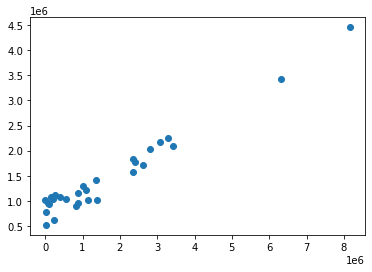

In [51]:
plt.scatter(heat_demand.values, heat_demand_guess[2018].reindex(heat_demand.index.astype(int)).values)

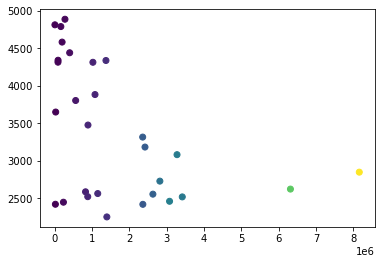

In [60]:
plt.scatter(heat_demand.values, hdd.reindex(heat_demand.index).values, c=population.reindex(heat_demand.index).values)

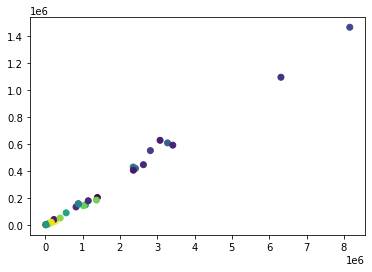

In [59]:
plt.scatter(heat_demand.values, population.reindex(heat_demand.index).values, c= hdd.reindex(heat_demand.index).values)

In [69]:
(demand.xs('CHE', level='country_code').sum().apply(tj_to_twh)*1e9).mul(pop_with_hdd_weights.xs('CHE', level='country_code').population, axis=1)

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

In [76]:
pop_with_hdd_weights.xs('CHE', level='country_code').population.to_frame(0).T

site,1033,1034,1035,1036,1037,1088,1089,1090,1091,1140,...,936,937,938,939,940,981,982,983,984,985
0,0.024783,0.01821,0.011054,0.177615,0.054243,0.001146,0.017399,0.050939,0.016323,0.002817,...,0.002565,0.022474,0.073796,0.07178,0.049285,0.000328,0.006406,0.01897,0.132734,0.021894


In [80]:
bar = (demand.xs('CHE', level='country_code').sum().apply(tj_to_twh)*1e9).to_frame().dot(pop_with_hdd_weights.xs('CHE', level='country_code').population.to_frame(0).T).loc[2017]

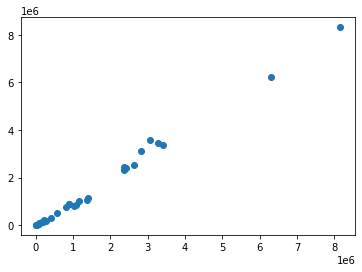

In [81]:
fig, ax = plt.scatter(heat_demand.values, bar.reindex(heat_demand.index.astype(int)).values)

In [9]:
energy_balance_ds = xr.open_dataset(energy_balance)
#
#hh_end_use_df = pd.read_csv(hh_end_use, delimiter='\t', index_col=0)
#hh_end_use_df.index = hh_end_use_df.index.str.split(',', expand=True).rename(['cat_code', 'carrier_code', 'unit', 'country'])
#hh_end_use_df.columns = hh_end_use_df.columns.astype(int)
#hh_end_use_df = hh_end_use_df.xs('TJ', level='unit')
#hh_end_use_df = hh_end_use_df.where(hh_end_use_df != ':').where(hh_end_use_df != ': ').astype(float).groupby(
#    [hh_end_use_cat_codes, 
#     {get_alpha2(i): get_alpha2(i) for i in countries}, 
#     {i: i for i in hh_end_use_df.index.get_level_values('carrier_code').unique()}], 
#    level=['cat_code', 'country', 'carrier_code']
#).sum()
#
#hh_energy_use = (
#    energy_balance_ds
#    .where(energy_balance_ds.sub_cat_2 == 'Households', drop=True)
#    .to_dataframe()
#    .groupby([hh_end_use_carrier_codes, {i: i for i in hh_end_use_df.columns}], level=['carrier_code', 'year'])
#    .sum()
#    .T
#    .rename(index={'EL': 'GR', 'UK': 'GB'})
#    .stack(0)
#)
#hh_energy_use_tot = (
#    energy_balance_ds
#    .where((energy_balance_ds.sub_cat_2 == 'Households'), drop=True)
#    .loc[{'carrier_code': 'TOTAL', 'year': 2017}]
#    .to_dataframe()
#    .T
#    .rename(index={'EL': 'GR', 'UK': 'GB'})
#    .loc[:, 'FC_OTH_HH_E']
#    .reindex(hh_energy_use.index)
#)

#hh_end_use_df = get_eu_sheet(hh_end_use, 'Table 3')
#hh_end_use_df_sh = get_eu_sheet(hh_end_use,'Table 4 Spaceheating')
#hh_end_use_df_hw = get_eu_sheet(hh_end_use,'Table 5 Waterheating')
#hh_end_use_df_c = get_eu_sheet(hh_end_use, 'Table 6 Cooking')

ch_hh_end_use_df_tot = get_ch_sheet(ch_end_use, 'Tabelle 15', skipfooter=5).groupby(ch_hh_end_use_translation).sum()
ch_hh_end_use_df_tot.index.rename('cat_name', inplace=True)
ch_hh_end_use_df_sh = get_ch_sheet(ch_end_use,'Tabelle 18', skipfooter=8).groupby(ch_energy_carrier_translation).sum()
ch_hh_end_use_df_hw = get_ch_sheet(ch_end_use,'Tabelle 20', skipfooter=5).groupby(ch_energy_carrier_translation).sum()
ch_hh_end_use_df_c = get_ch_sheet(ch_end_use, 'Tabelle21', skipfooter=4).groupby(ch_energy_carrier_translation).sum()

ch_hh_end_use_df = (
    pd.concat(
        [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c], 
        keys=('space_heating', 'water_heating', 'cooking'), 
        names=['cat_name', 'carrier_name']
    )
    .append(ch_hh_end_use_df_tot.assign(carrier_name='total').set_index('carrier_name', append=True))
    .assign(unit='TJ', country='CH')
    .set_index(['unit', 'country'], append=True)
    .drop('Δ ’00 – ’18', axis=1)
)
ch_hh_end_use_df.columns = ch_hh_end_use_df.columns.astype(int)

In [10]:
hh_end_use_df = hh_end_use_df.append(ch_hh_end_use_df, sort=True).sort_index()
hh_end_use_df = hh_end_use_df.where(hh_end_use_df > 0).dropna(how='all')

In [14]:
hh_energy_use = (
    energy_balance_ds
    .where(energy_balance_ds.sub_cat_2 == 'Households', drop=True)
    .to_dataframe()
    .groupby([hh_end_use_carrier_codes, {i: i for i in range(2000, 2019)}], level=['carrier_code', 'year'])
    .sum()
    .T
    .rename(index={'EL': 'GR', 'UK': 'GB'})
    .stack(0)
)

In [15]:
hh_energy_use

year                      2010          2011          2012          2013  \
   carrier_code                                                            
SE ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas            65.849814     12.611063     29.999045     35.038693   
   biomass          617.965988   1170.344893   1189.261488    968.782841   
   coal               0.000000      0.000000      0.000000      0.000000   
   electricity     3953.740327   3641.788478   3775.494411   3740.670679   
   heat            3233.710710   2504.561957   2734.045094   2643.856884   
   natural_gas       76.053310     69.475494     45.120378     33.404987   
   oil              310.049926    263.132027    259.031936    251.503602   
   solar_thermal     10.318143     11.010796     11.082450     11.177988   
   total           8282.351803   7684.931276   8056.624087   7696.895963   
DE ambient_heat     476.569218    547.625872    624.486481    702.851820   
   biogas           138.363428    166.069552    199.101939    227.572370   
   biomass         6646.651381   5931.809497   7067.880004   7326.144072   
   coal             992.141564    865.783009    742.844941    691.631461   
   electricity    12184.006879  11745.485813  11779.879622  11693.895099   
   heat            4511.416834   3925.360657   3376.134518   4406.372409   
   natural_gas    23906.706793  19757.975064  21618.766122  22509.200344   
   oil            14337.902073  12366.641588  13028.519490  14208.842720   
   solar_thermal    454.953664    521.233400    542.538454    548.414063   
   total          63838.844153  56020.306368  59188.186539  62517.366748   
PL ambient_heat      18.971780     23.091396     27.211013     29.827568   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass         2692.891946   2746.727811   2790.914302   2790.914302   
   coal            7886.419987   6804.855498   7186.405608   6919.582736   
   electricity     2460.447120   2429.750645   2434.909716   2445.571797   
   heat            4657.494984   4179.803191   4299.226139   4203.687781   
   natural_gas     3545.120378   3235.662081   3377.214101   3419.969905   
   oil              701.884494    663.107863    639.321200    599.121047   
   solar_thermal      7.643069      9.267221     10.891373     20.445209   
   total          21982.973690  20103.954824  20779.220424  20443.637399   
...                        ...           ...           ...           ...   
AL ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass          179.994268    170.010509    160.002866    160.002866   
   coal               0.000000      0.000000      0.235096      0.235096   
   electricity      222.527945    233.190026    262.252794    331.900258   
   heat               0.000000      0.000000      0.000000      0.000000   
   natural_gas        0.000000      0.000000      0.000000      0.000000   
   oil               84.510294     89.705025     81.221219     82.490279   
   solar_thermal      2.006306      5.374033      5.374033      5.374033   
   total            489.038812    498.279593    509.086008    580.002532   
FI ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass         1481.131174   1264.903984   1366.150760   1251.433075   
   coal               8.081542      5.619853      5.630386      4.737795   
   electricity     1969.389510   1842.304385   1924.505589   1849.527085   
   heat            1740.756664   1509.792682   1660.528327   1598.285086   
   natural_gas       46.044712     30.932932     33.319003     29.449699   
   oil              608.206602    470.165281    493.600363    435.439954   
   solar_thermal      0.931499      1.027037      1.122576      1.241999   
   total           5870.467315   5138.457738   5

In [8]:
hh_end_use_df.stack().unstack('carrier_name')#loc(['CH'], level='country').xs('space_heating', level='cat_name').transform(tj_to_twh)

carrier_name                     ambient_heat  biogas   biomass      coal  \
cat_name      unit country                                                  
cooking       TJ   AL      2010           NaN     NaN  2557.351       NaN   
                           2011           NaN     NaN  2505.464       NaN   
                           2012           NaN     NaN  2615.665       NaN   
                           2013           NaN     NaN  2360.031       NaN   
                           2014           NaN     NaN  2518.860       NaN   
                           2015           NaN     NaN  2339.092       NaN   
                           2016           NaN     NaN  2176.486       NaN   
                           2017           NaN     NaN  1886.153       NaN   
                           2018           NaN     NaN  1813.609       NaN   
                   AT      2010           NaN   0.050   374.194     5.642   
                           2011           NaN   0.183   411.451     6.464   
                           2012           NaN   0.207   446.095     6.898   
                           2013           NaN   0.331   438.395     3.761   
                           2014           NaN   0.564   429.441     1.824   
                           2015           NaN   0.730   366.359     2.001   
                           2016           NaN   0.863   310.616     2.497   
                           2017           NaN   1.323   311.279     2.681   
                           2018           NaN   0.995   283.228     2.398   
                   BA      2014           NaN     NaN   510.000    11.044   
                           2015           NaN     NaN   687.000    10.886   
                           2016           NaN     NaN   687.000    21.606   
                           2017           NaN     NaN   549.000    32.211   
                           2018           NaN     NaN  1709.530    19.971   
                   BE      2016           NaN     NaN       NaN       NaN   
                           2017           NaN     NaN       NaN       NaN   
                           2018           NaN     NaN       NaN       NaN   
                   BG      2010           NaN     NaN   565.611   338.991   
                           2011           NaN     NaN   594.206   408.426   
                           2012           NaN     NaN   603.573   408.215   
                           2013           NaN     NaN   596.334   328.801   
...                                       ...     ...       ...       ...   
water_heating TJ   RS      2015           NaN     NaN    71.000    74.284   
                           2016           NaN     NaN    73.000    90.995   
                           2017           NaN     NaN    67.282    85.937   
                           2018           NaN     NaN    70.418    80.633   
                   SE      2015           NaN     NaN       NaN       NaN   
                           2016           NaN     NaN       NaN       NaN   
                           2017           NaN     NaN       NaN       NaN   
                           2018           NaN  76.000  3673.000       NaN   
                   SI      2010       158.322     NaN  2192.226    12.304   
                           2011       206.558     NaN  2319.015     8.960   
                           2012       281.842     NaN  2289.053     6.464   
                           2013       347.384     NaN  2334.618     4.544   
                           2014       408.573     NaN  2143.809     3.024   
                           2015       452.174     NaN  2196.802     2.272   
                           2016       493.370     NaN  2195.243     1.584   
                           2017       522.627     NaN  2131.609     1.104   
                           2018       553.966     NaN  2105.903     0.800   
                   SK      2015           NaN     NaN    81.920   263.700   
                           2016           NaN     NaN   109.200   445.600

In [52]:
pd.concat(
    [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c], 
    keys=('space_heating', 'water_heating', 'cooking'), 
    names=['cat_name', 'carrier_name']
).assign(country_code='CH').set_index('country_code', append=True)

2000           2001  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              2674.598421    3132.807306   
              biomass         CH             16109.808467   17305.138394   
              coal            CH               355.246238     389.457239   
              direct_electric CH             10600.067925   11397.772579   
              heat            CH              4398.831631    4936.881889   
              heat_pump       CH              1487.798515    1711.777867   
              natural_gas     CH             27631.643037   30916.515159   
              oil             CH            104224.750817  112612.498387   
water_heating ambient_heat    CH               303.635791     315.912081   
              biomass         CH               995.563502    1003.102052   
              direct_electric CH              8138.141716    8165.250827   
              heat            CH               873.407951     875.420325   
              heat_pump       CH               201.971321     209.967184   
              natural_gas     CH              5065.271320    5131.214038   
              oil             CH             16645.412470   16314.598630   
              solar_thermal   CH               112.265308     141.554347   
cooking       biomass         CH               220.345791     204.623216   
              electricity     CH              8010.061688    8062.290797   
              natural_gas     CH               584.386393     563.007731   

                                                     2002           2003  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              3109.900826    3632.988938   
              biomass         CH             16282.359592   17392.809930   
              coal            CH               367.757196     404.702288   
              direct_electric CH             10843.411329   11723.585935   
              heat            CH              4697.660337    5217.268707   
              heat_pump       CH              1669.107831    1908.702640   
              natural_gas     CH             29302.937568   32478.614275   
              oil             CH            103371.656970  110472.865641   
water_heating ambient_heat    CH               332.868566     356.951938   
              biomass         CH              1012.896313    1034.365227   
              direct_electric CH              8185.154471    8304.177000   
              heat            CH               876.276356     885.536015   
              heat_pump       CH               220.719025     236.048876   
              natural_gas     CH              5237.188626    5407.117120   
              oil             CH             15967.443092   15765.692687   
              solar_thermal   CH               176.765937     215.220730   
cooking       biomass         CH               191.136360     180.981866   
              electricity     CH              8107.848157    8159.121740   
              natural_gas     CH               551.177742     533.627780   

                                                     2004           2005  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              3904.888515    4452.571683   
              biomass         CH             17224.440545   17813.369655   
              coal            CH               383.726550     402.697996   
              direct_electric CH             11727.288517   12182.262440   
              heat            CH              5286.401994    5636.425785   
              heat_pump       CH              2011.211530    2259.217022   
              natural_gas     CH             32729.972368   34624.839995   
              oil             CH            107238.657276  108919.059105   
water_heating ambient_heat    CH               384.802164     421.939062   
              biomass  

In [38]:
ch_hh_end_use_df_c

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Δ ’00 – ’18
biomass,220.345791,204.623216,191.136360,180.981866,176.900062,161.558101,161.312743,156.27229,151.862262,147.515360,142.850401,138.321451,134.614708,130.814127,127.160615,123.307613,119.380151,115.226255,110.599434,-498.064232
natural_gas,584.386393,563.007731,551.177742,533.627780,507.464063,480.793015,448.182420,421.03954,383.085548,358.419032,345.323102,331.873533,320.526135,309.070639,298.443952,283.089775,282.885787,282.653260,280.548606,-519.926184


In [33]:
ch_hh_end_use_df_sh.loc['ambient_heat'] / ch_hh_end_use_df_sh.loc['heat_pump']

2000           1.797689
2001           1.830148
2002           1.863211
2003           1.903381
2004           1.941560
2005           1.970847
2006           1.990529
2007           1.991891
2008           1.988921
2009           1.988621
2010           1.996962
2011           2.009665
2012           2.019695
2013           1.999076
2014           2.016395
2015           2.033970
2016           2.032067
2017           2.049178
2018           2.067177
Δ ’00 – ’18    1.209037
dtype: float64

In [67]:
hh_energy_use.sort_index(level=0).xs('TOTAL', level='carrier_code').sort_index(ascending=False, axis=1)

year,2018,2017,2016,2015,2014,2013,2012,2011,2010
AL,510.483978,492.579560,496.349885,532.286973,556.243026,580.002532,509.086008,498.279593,489.038812
AT,6492.035264,6947.883701,6883.635515,6618.646644,6244.831046,6947.919629,6678.734832,6550.260261,7069.594305
BE,8103.423727,8171.032987,8312.851968,8270.409360,7486.618907,9062.178599,8360.865100,7986.877090,9527.492238
BG,2229.672098,2318.715170,2252.111039,2192.910887,2164.990804,2241.035851,2352.559162,2374.280883,2243.337155
CH,5348.715009,5655.393140,5767.411866,5567.497850,5236.935129,6201.394860,5844.081399,5403.410719,6347.329703
CY,337.178682,345.145636,335.593532,326.614479,293.741879,306.622194,351.763447,356.537690,336.523837
CZ,7044.900999,7204.762542,7091.810237,6771.004323,6555.520565,7270.215630,7116.226474,6863.669533,7440.746561
DE,55258.362751,56542.650748,56963.706267,54959.824042,53648.201610,62517.366748,59188.186539,56020.306368,63838.844153
DK,4619.812217,4591.291316,4625.833672,4454.332772,4148.220307,4484.149780,4444.453146,4496.270357,5005.141894
EE,941.045025,942.495462,930.578246,857.435273,888.143164,933.506282,970.827912,935.253320,1026.848572


In [115]:
energy_balances = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_bal_c.tsv.gz', delimiter='\t', index_col=0)
energy_balances.index = energy_balances.index.str.split(',', expand=True).rename(['cat_code', 'carrier_code', 'unit', 'country'])
energy_balances = energy_balances.transform(lambda x: pd.to_numeric(x, errors='coerce'))

In [124]:
energy_balances = energy_balances.reorder_levels([
        'cat_code', 'carrier_code', 'unit', 'country'
    ]).loc[
    energy_balance_ds.cat_code.values, energy_balance_ds.carrier_code.values, 'TJ', [get_alpha2(i) for i in countries]
].dropna(how='all')

In [127]:
len(energy_balances.index.get_level_values('country').unique())

34

In [130]:
energy_balances_ds = energy_balances.stack().unstack('country').to_xarray()

In [86]:
energy_balance_ds.cat_code

<xarray.DataArray 'cat_code' (cat_code: 127)>
array(['AFC', 'DL', 'EXP', 'FC_E', 'FC_IND_CON_E', 'FC_IND_CPC_E', 'FC_IND_E',
       'FC_IND_FBT_E', 'FC_IND_IS_E', 'FC_IND_MAC_E', 'FC_IND_MQ_E',
       'FC_IND_NE', 'FC_IND_NFM_E', 'FC_IND_NMM_E', 'FC_IND_NSP_E',
       'FC_IND_PPP_E', 'FC_IND_TE_E', 'FC_IND_TL_E', 'FC_IND_WP_E', 'FC_NE',
       'FC_OTH_AF_E', 'FC_OTH_CP_E', 'FC_OTH_E', 'FC_OTH_FISH_E',
       'FC_OTH_HH_E', 'FC_OTH_NE', 'FC_OTH_NSP_E', 'FC_TRA_DAVI_E',
       'FC_TRA_DNAVI_E', 'FC_TRA_E', 'FC_TRA_NE', 'FC_TRA_NSP_E',
       'FC_TRA_PIPE_E', 'FC_TRA_RAIL_E', 'FC_TRA_ROAD_E', 'FEC2020-2030',
       'GAE', 'GIC', 'GIC2020-2030', 'IMP', 'INTAVI', 'INTMARB', 'NRGSUP',
       'NRG_BF_E', 'NRG_BIOG_E', 'NRG_BKBPB_E', 'NRG_CL_E', 'NRG_CM_E',
       'NRG_CO_E', 'NRG_CPP_E', 'NRG_E', 'NRG_EHG_E', 'NRG_GTL_E', 'NRG_GW_E',
       'NRG_LNG_E', 'NRG_NE', 'NRG_NI_E', 'NRG_NSP_E', 'NRG_OIL_NG_E',
       'NRG_PF_E', 'NRG_PR_E', 'PEC2020-2030', 'PPRD', 'RCV_RCY', 'STK_CHG',
       'TI_BF

In [84]:
energy_balances.transform(lambda x: pd.to_numeric(x, errors='coerce'))

2018         2017         2016   \
cat_code  carrier_code unit country                                            
AFC       BIOE         GWH  AL            3129.617     2804.720     3049.733   
                            AT           55305.885    58210.991    57658.982   
                            BA           13379.486     4843.579     5936.294   
                            BE           27929.856    27124.591    27065.456   
                            BG           16312.768    14661.761    14428.844   
                            CY             912.676      804.888      638.385   
                            CZ           37867.859    37604.370    37275.094   
                            DE          218991.678   219326.911   215808.508   
                            DK           40515.420    40127.918    36688.905   
                            EA19        895057.848   871472.005   847093.982   
                            EE            9671.807     8968.210     8443.650   
                            EL           12739.524    12928.130    12761.756   
                            ES           73902.392    55399.615    54002.808   
                            EU27_2020  1274902.659  1254399.934  1216197.082   
                            EU28       1359618.689  1327347.130  1287693.521   
                            FI          105101.105   102747.280    96802.715   
                            FR          161590.450   160865.174   161188.294   
                            GE            3147.417     4225.250     4493.611   
                            HR           14293.259    14256.833    14221.776   
                            HU           24952.718    27293.994    28215.386   
                            IE            5313.363     5432.289     4570.808   
                            IS             473.414      422.974      334.137   
                            IT          121184.340   124094.135   116885.879   
                            LT           14261.243    13870.999    13139.971   
                            LU            3052.801     2694.638     2290.223   
                            LV           16792.267    15311.920    13884.547   
                            MD            9101.391     8822.123     8022.958   
                            ME            1750.222     1903.556     1938.000   
                            MK            2291.520     2694.324     2297.949   
                            MT             154.121      121.772      110.215   
...                                            ...          ...          ...   
TO_RPI_RO W6220        TJ   EL                 NaN          NaN          NaN   
                            ES                 NaN          NaN          NaN   
                            FI                 NaN          NaN          NaN   
                            FR                 NaN          NaN          NaN   
                            GE                 NaN          NaN          NaN   
                            HR                 NaN          NaN          NaN   
                            HU                 NaN          NaN          NaN   
                            IE                 NaN          NaN          NaN   
                            IS                 NaN          NaN          NaN   
                            IT                 NaN          NaN          NaN   
                            LT                 NaN          NaN          NaN   
                            LU                 NaN          NaN          NaN   
                            LV                 NaN          NaN          NaN   
                            MD                 NaN          NaN          NaN   
                            ME                 NaN          NaN          NaN   
                            MK                 NaN          NaN          NaN   
                            MT                 NaN          NaN          NaN   
                            NL               

In [67]:
hh_end_use_df_abs = get_absolute_vals(hh_end_use_df, hh_energy_use_tot)
hh_end_use_df_sh_abs = get_absolute_vals(hh_end_use_df_sh, hh_end_use_df_abs['Space heating'])
hh_end_use_df_hw_abs = get_absolute_vals(hh_end_use_df_hw, hh_end_use_df_abs['Water heating'])
hh_end_use_df_c_abs = get_absolute_vals(hh_end_use_df_c, hh_end_use_df_abs['Cooking'])

discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))
over = discrepency > 0
under = discrepency < 0
end_use_contributions = hh_end_use_df_abs[['Space heating', 'Cooking', 'Water heating']].transform(lambda x: x / x.sum(), axis=1)
over_under = {'Space heating': {}, 'Cooking': {}, 'Water heating': {}}
for k, v in over_under.items():
    over_under[k]['over'] = discrepency[over].mul(end_use_contributions[k], axis=0)
    over_under[k]['under'] = discrepency[under].mul(end_use_contributions[k], axis=0)
    over_under[k]['over'] = over_under[k]['over'].where(
        over_under[k]['over'] < hh_end_use_df_hw_abs[over_under[k]['over'].columns],
        other=hh_end_use_df_hw_abs[over_under[k]['over'].columns]
    )
order = ['Derived Heat', 'Renewables and Wastes', 'Gas', 'Solid fuels', 'Oil & petroleum products']
_added = {}
for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
    _over = over_under[k]['over'].sum(axis=1)
    _added[k] = pd.DataFrame(index=v.index, data=0, columns=order)
    for i in order:
        _leftover = over_under[k]['under'][i].fillna(0) + _over
        _added[k][i] = _over.where(_leftover < 0, other=-1 * over_under[k]['under'][i])
        _over = _leftover.where(_leftover >= 0, other=0)
    _added[k]['Electricity'] = _over  # everything that's left over goes to electricity
    
    v += _added[k].T.reindex(v.columns).fillna(0).T
    v -= over_under[k]['over'].T.reindex(v.columns).fillna(0).T
    
discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

#for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
#    _under = discrepency[under].mul(end_use_contributions[k], axis=0)
#    
#    v.loc[:, order] += -1 * _under[order].fillna(0)
#    v.loc[:, 'Electricity'] += _under[order].fillna(0).sum(axis=1)

In [82]:
discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))
over = discrepency > 0
under = discrepency < 0
end_use_contributions = hh_end_use_df_abs[['Space heating', 'Cooking', 'Water heating']].transform(lambda x: x / x.sum(), axis=1)

order = ['Derived Heat', 'Renewables and Wastes', 'Gas', 'Solid fuels', 'Oil & petroleum products']
_added = {}
for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
    _over = discrepency[over].mul(end_use_contributions[k], axis=0)
    _under = discrepency[under].mul(end_use_contributions[k], axis=0)
    _over = _over.where(
        _over < v[_over.columns], other=v[_over.columns]
    )
    _over_tot = _over.sum(axis=1)
    _added[k] = pd.DataFrame(index=v.index, data=0, columns=order)
    for i in order:
        _leftover = _under[i].fillna(0) + _over_tot
        _added[k][i] = _over_tot.where(_leftover < 0, other=(-1 * _under[i]).fillna(0))
        _over_tot = _leftover.where(_leftover >= 0, other=0)
    _added[k]['Electricity'] = _over_tot  # everything that's left over goes to electricity
    
    v += _added[k].T.reindex(v.columns).fillna(0).T
    v -= _over.T.reindex(v.columns).fillna(0).T

In [83]:
(hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,2.49496,4238.11,-2426.03,-2273.08,-611.421,0.0160151
BG,-328.015,424.226,0,-3.55271e-15,-564.628,0
CZ,-1209.8,3750.22,-1403.13,-42.0166,-1709.41,1.88055
DK,-2304.24,2997.24,-271.101,-10.4183,-1074.71,0
DE,718.338,19202.5,-9825.55,-10593.8,-5386.74,0.14492
EE,-268.082,571.191,-31.1921,0.092714,-353.443,0.106215
IE,8.60907,658.939,-233.376,-603.766,-13.2989,-309.819
GR,-51.0528,478.828,-320.881,-596.585,-631.488,0.00130654
ES,0,-229.799,-1871.77,0,-2253.55,0
FR,-1277.48,12534.1,-9489.75,0,-8816.4,0


In [35]:
discrepency_use_df_hw_abs

,Electricity,Derived Heat,Gas,Solid fuels,Oil & petroleum products,Renewables and Wastes
BE,286.159,0,460.291,0.198427,162.567,24.7815
BG,234.207,125.247,9.03168,2.90963,0.624348,25.8065
CZ,264.089,341.716,450.542,27.7378,0,85.6539
DK,45.9575,613.949,155.966,0,94.7618,62.7001
DE,1358.24,392.57,4376.77,0,1610.04,1351.95
EE,22.3323,80.0293,16.5931,0.998538,6.26815,48.8958
IE,80.7087,0,152.1,32.4971,225.499,24.0278
GR,269.744,2.27873,14.5434,0,43.6335,265.295
ES,428.647,0,1524.85,4.80505,560.37,271.447
FR,2207.19,284.97,1205.35,2.99964,583.131,172.355


In [158]:
hh_energy_use.loc['CH']

carrier_code
Derived Heat                 184.866724
Electricity                 1653.291296
Gas                         1158.163753
Oil & petroleum products    1820.244578
Renewables and Wastes        368.778064
Solid fuels                    2.388459
Name: CH, dtype: float64

In [139]:
(hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,0,-1037.6,0,-32.3209,0,0
BG,0,-472.035,0,0,0,-2.84217e-14
CZ,-2.27374e-13,-609.688,-2.25577,-0.314218,0,0
DK,0,-646.656,-5.46972,-11.1108,0,0
DE,0,-5579.03,-7.27596e-12,-1.81899e-12,-306.057,0
EE,0,-129.987,0,0,0,-4.44089e-16
IE,0,-493.549,0,0,-7.10543e-15,0
GR,0,-1088.01,-5.68434e-14,0,-33.1681,0
ES,0,-4754.11,0,0,-4.54747e-13,0
FR,0,-7162.46,0,0,0,0


In [119]:
hh_end_use_df_c_abs + _added['Space heating'].T.reindex(hh_end_use_df_c_abs.columns).fillna(0).T

,Electricity,Derived Heat,Gas,Solid fuels,Oil & petroleum products,Renewables and Wastes
BE,82.402,5.12618,44.3066,0,23.3764,15.8654
BG,142.436,0.87313,3.71945,2.16371,22.7928,25.1627
CZ,203.96,4.41051,233.608,0.808244,8.89702,113.642
DK,72.5912,0,24.2332,0,0,0
DE,3367.54,0,87.9752,0,0,587.398
EE,9.86765,17.2833,25.4854,0.00181883,12.3304,19.8225
IE,47.9705,0,14.3919,0,15.3275,0.0561447
GR,196.776,0,0.305567,0,14.1268,12.2284
ES,533.189,0,388.477,11.3468,214.11,199.598
FR,1051.29,0,740.249,0.557836,457.34,0


In [72]:
while reassign_energy(reassign_energy(reassign_energy(foo)))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,0,-1025.49,0,-37.8559,-6.57116,0
BG,0,-468.417,0,0,0,0
CZ,0,-542.328,0,0,-69.9301,0
DK,0,-640.643,-17.4949,-5.09822,0,0
DE,0,-5300.69,0,0,-584.397,0
EE,0,-81.3279,0,0,0,0
IE,0,-483.245,0,-9.46834,0,0
GR,0,-1083.66,0,0,-37.5202,0
ES,0,-4355.12,0,0,0,0
FR,0,-7049.54,0,0,0,0


In [64]:
foo + over.fillna(0).sum(axis=1) / under.sum(axis=1)

,AL,AT,BE,BG,CY,CZ,DE,DK,Derived Heat,EE,...,Oil & petroleum products,PL,PT,RO,RS,Renewables and Wastes,SE,SI,SK,Solid fuels
BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
over = foo.where(foo > 0)

In [56]:
under = foo < 0

In [74]:
energy_balance_ds.where(energy_balance_ds.sub_cat_2 == 'Households', drop=True).EE.loc[{'carrier_code': 'TOTAL', 'year': 2018}]

<xarray.DataArray 'EE' (cat_code: 1)>
array([941.045025])
Coordinates:
  * cat_code              (cat_code) object 'FC_OTH_HH_E'
    carrier_code          <U5 'TOTAL'
    year                  int64 2018
    top_cat               (cat_code) object 'Final energy consumption'
    sub_cat_contribution  (cat_code) object '+'
    sub_cat_1             (cat_code) object 'Other sectors'
    sub_cat_2             (cat_code) object 'Households'
    carrier_name          object 'Total'

In [6]:
countries_alpha2 = {}
for i in countries:
    if i == 'Greece':
        countries_alpha2[i] = 'EL'

XK
EL
TR
MD
GE
MT
UK
CY


In [9]:
pycountry.countries.lookup('EL')

LookupError: Could not find a record for 'el'